# Sentiment analysis on Covid-19 tweets with machine learning classifiers

Classify 45k tweets on Covid-19 as positive or negative based on the following machine learning models: 

* Multinomial Naive Bayes Model
* Random Forests 
* ADABoost
* XGBoost

The tweets are preprocessed using the following NLP methods: 

* Bag-of-words model
* Bag-of-POS model
* Pre-trained word embeddings


In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import string
import joblib

from warnings import filterwarnings
filterwarnings("ignore")

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from __future__ import absolute_import, division, print_function, unicode_literals
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import collections
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from tune_sklearn import TuneGridSearchCV

In [3]:
def preprocessor(text):
    # convert to lowercase, susbstitute non alphanumerical characters with whitespaces
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [4]:
def test_performance(model, X_test): 
    ''' Given a fitted model and a test set, returns optimal hyperparameters, AUC and accuracy '''
    clf_b = model.best_estimator_
    y_pred_proba = clf_b.predict_proba(X_test)
    y_pred = clf_b.predict(X_test)

    # performance metrics
    auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])
    acc = accuracy_score(y_test, y_pred)
    
    return (model.best_params_, auc_res, acc)


In [5]:
stopwords = list(set(stopwords.words("english")))

# Data analytics

* There are no duplicated values in the dataset
* Missing values only in the location feature
* Most tweets have positive sentiment
* On average, each tweet has about 30 words

In [27]:
train_data=pd.read_csv("./Corona_NLP_train.csv",encoding="latin1")
test_data=pd.read_csv("./Corona_NLP_test.csv",encoding="latin1")

In [28]:
# merge train and test datasets
df = pd.concat([train_data, test_data], axis = 0)
df.shape

(44955, 6)

In [29]:
# duplicated tweets
duplicates = df[df.duplicated()]
len(duplicates)

0

In [30]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [31]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<AxesSubplot:xlabel='Sentiment'>

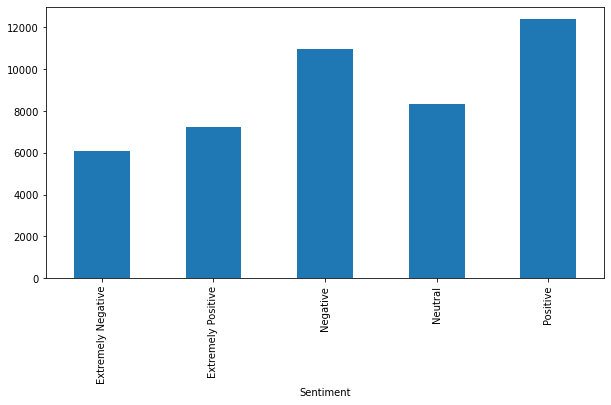

In [32]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [33]:
# remove neutral tweets
df.drop(df[df.Sentiment == "Neutral"].index, inplace = True)

df.Sentiment.unique()

array(['Positive', 'Negative', 'Extremely Positive', 'Extremely Negative'],
      dtype=object)

In [34]:
# Aggregate extremely positive/negative values
df = df.replace("Extremely Positive", "Positive")
df = df.replace("Extremely Negative", "Negative")

df.Sentiment.unique()

array(['Positive', 'Negative'], dtype=object)

<AxesSubplot:xlabel='Sentiment'>

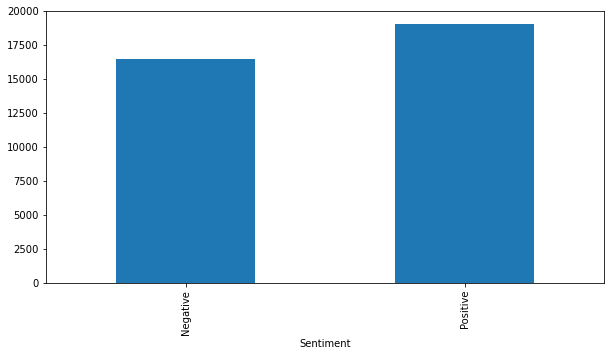

In [35]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")
fig, ax = plt.subplots(figsize=(10,5))

counts.plot.bar()

In [36]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive


In [37]:
# count number of words per headline. strip whitespaces at the beginning/end of the sentence 
# and tokenize by whitespace
df_select = df[["OriginalTweet", "Sentiment"]]
df_select["word_count"] = df_select["OriginalTweet"].apply(lambda x: len(x.strip().split(" ")))
df_select.head()

,OriginalTweet,Sentiment,word_count
1,advice Talk to your neighbours family to excha...,Positive,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,14
3,My food stock is not the only one which is emp...,Positive,40
6,Cashier at grocery store was sharing his insig...,Positive,28
8,Due to COVID-19 our retail store and classroom...,Positive,46


In [38]:
# summary statistics of word counts
df_select["word_count"].describe()

count    35555.000000
mean        32.130108
std         11.063108
min          1.000000
25%         24.000000
50%         33.000000
75%         41.000000
max        127.000000
Name: word_count, dtype: float64

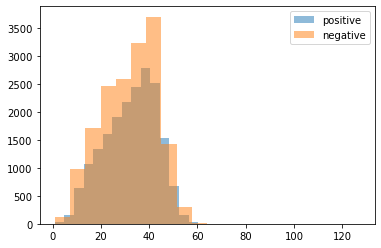

In [39]:
# distributions of word counts by sentiment
pos = df_select[df_select.Sentiment == "Positive"].word_count
neg =  df_select[df_select.Sentiment == "Negative"].word_count

plt.hist(pos, bins = 20, alpha = 0.5, label='positive')
plt.hist(neg, bins = 20, alpha = 0.5, label='negative')
plt.legend(loc='upper right')
plt.show()

In [40]:
df_select

,OriginalTweet,Sentiment,word_count
1,advice Talk to your neighbours family to excha...,Positive,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,14
3,My food stock is not the only one which is emp...,Positive,40
6,Cashier at grocery store was sharing his insig...,Positive,28
8,Due to COVID-19 our retail store and classroom...,Positive,46
...,...,...,...
3791,"With Gov Hogan's announcement that all bars, r...",Negative,43
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative,29
3793,Meanwhile In A Supermarket in Israel -- People...,Positive,18
3796,Gov need to do somethings instead of biar je r...,Negative,29


In [41]:
# save dataset
df_select.to_csv("binary_data.csv",index = False, encoding = "utf-8")

# NLP Preprocessing

## Basic preprocessing: 

* Convert tweets to lowercase
* Remove punctuation and non alphanumerical characters

In [42]:
df = pd.read_csv("binary_data.csv")

In [43]:
# select random tweet
text = df.OriginalTweet.iloc[400]
text

"If there's an elderly person/couple that cant make it to the grocery store or simply doesn't want to go, I'd be happy to go for you.\r\r\n\r\r\nIf you know someone in need in or around Lewisville/Frisco please DM me and well try to figure this out.\r\r\n\r\r\n#coronavirus"

In [44]:
# preprocess entire corpus
df['tweet_clean'] = df['OriginalTweet'].apply(preprocessor)
df.head()

,OriginalTweet,Sentiment,word_count,tweet_clean
0,advice Talk to your neighbours family to excha...,Positive,38,advice talk to your neighbours family to excha...
1,Coronavirus Australia: Woolworths to give elde...,Positive,14,coronavirus australia woolworths to give elder...
2,My food stock is not the only one which is emp...,Positive,40,my food stock is not the only one which is emp...
3,Cashier at grocery store was sharing his insig...,Positive,28,cashier at grocery store was sharing his insig...
4,Due to COVID-19 our retail store and classroom...,Positive,46,due to covid 19 our retail store and classroom...


## Bag-of- models

Bag-of- models are used to produce a real-valued representation of a text document that can used to train a ML model.

* Bag-of-words: count (with normalization) the occurences of each token in a text
* Bag-of-POS: count the occurence of each POS tag in a text. A POS is a set of words with similar sytactic behaviour (nouns, adjective, verbs, pronouns etc). POS tags are assigned to every word in a document and used in bag-of machine learning models. 

Bag-of-word models suffer from high dimensionality and sparseness of the real-valued representation. Bag-of-POS is usually more parsimonious than bag-of-words, since there usually are less POS-tags than words in a document, and can therefore be used to reduce dimensionality.

In [45]:
# tokenize the dataset with nltk tokenizer
text_processed = df.tweet_clean.apply( word_tokenize )
text_processed

0        [advice, talk, to, your, neighbours, family, t...
1        [coronavirus, australia, woolworths, to, give,...
2        [my, food, stock, is, not, the, only, one, whi...
3        [cashier, at, grocery, store, was, sharing, hi...
4        [due, to, covid, 19, our, retail, store, and, ...
                               ...                        
35550    [with, gov, hogan, s, announcement, that, all,...
35551    [ricepolitics, mdcounties, craig, will, you, c...
35552    [meanwhile, in, a, supermarket, in, israel, pe...
35553    [gov, need, to, do, somethings, instead, of, b...
35554    [i, and, forestandpaper, members, are, committ...
Name: tweet_clean, Length: 35555, dtype: object

In [46]:
# POS-tags for the whole dataset
text_tagged = text_processed.apply(pos_tag)
text_tagged

0        [(advice, NN), (talk, NN), (to, TO), (your, PR...
1        [(coronavirus, NN), (australia, NNS), (woolwor...
2        [(my, PRP$), (food, NN), (stock, NN), (is, VBZ...
3        [(cashier, NN), (at, IN), (grocery, NN), (stor...
4        [(due, JJ), (to, TO), (covid, VB), (19, CD), (...
                               ...                        
35550    [(with, IN), (gov, JJ), (hogan, NNS), (s, VBP)...
35551    [(ricepolitics, NNS), (mdcounties, NNS), (crai...
35552    [(meanwhile, RB), (in, IN), (a, DT), (supermar...
35553    [(gov, NNS), (need, VBP), (to, TO), (do, VB), ...
35554    [(i, NN), (and, CC), (forestandpaper, JJ), (me...
Name: tweet_clean, Length: 35555, dtype: object

In [47]:
def retrieve_tags(text):
    # form a string of tags from POS-tag text
    return "-".join(tag for (word, tag) in text)

df["text_pos"] = text_tagged.apply(retrieve_tags)
df.text_pos

0        NN-NN-TO-PRP$-NNS-NN-TO-VB-NN-NNS-VBP-JJ-NN-IN...
1        NN-NNS-NNS-TO-VB-RB-VBN-VBN-NN-NNS-IN-JJ-CD-JJ...
2        PRP$-NN-NN-VBZ-RB-DT-JJ-CD-WDT-VBZ-JJ-NN-VB-JJ...
3        NN-IN-NN-NN-VBD-VBG-PRP$-NNS-IN-NN-TO-VB-PRP$-...
4        JJ-TO-VB-CD-PRP$-JJ-NN-CC-NN-IN-NN-MD-RB-VB-JJ...
                               ...                        
35550    IN-JJ-NNS-VBP-NN-IN-DT-NNS-NNS-VBP-NN-TO-VB-NN...
35551    NNS-NNS-VBP-MD-PRP-VB-IN-DT-JJ-NN-TO-VB-DT-JJ-...
35552    RB-IN-DT-NN-IN-JJ-NNS-NN-CC-VBG-RB-TO-VB-JJ-NN...
35553    NNS-VBP-TO-VB-NNS-RB-IN-JJ-NN-NN-VBP-JJ-NN-CC-...
35554    NN-CC-JJ-NNS-VBP-VBN-TO-DT-NN-IN-PRP$-NNS-CC-P...
Name: text_pos, Length: 35555, dtype: object

In [48]:
# save dataset
df.to_csv("pos_tagged_data.csv",index = False, encoding = "utf-8")

## Word embeddings
Associate a real-valued vector to each word in a document, so that words that occur in similar context (i.e. are semantically close) have a similar vector representation.

* word2vec: compute word embeddings using the concept of context, i.e. the words around a certain word in the text. The embeddings are calculated based on the probability of each word to appear in the context of every other word (word-word co-occurrences).

* Glove: unsupervised learning model trained on word-word co-occurence counts, computed with respect to the entire document as opposed to one context window at a time. Embeddings are computed based on the probability of a word to appear in the context of another word, given the entire vocabulary.

Spacy offers pre-trained word embedding models (such as "en_core_web_md")

In [50]:
df = pd.read_csv("pos_tagged_data.csv")

In [51]:
# load pre-trained word embedding model from spacy
nlp = spacy.load('en_core_web_md') 

In [52]:
# example on random tweet
print( nlp(text) )
print( )
print( nlp(text).vector[:20])





#coronavirus

[-2.7490519e-02  2.0281416e-01 -2.2748066e-01 -1.4905868e-02
  1.6965389e-01  1.5237168e-02  7.1119017e-04 -1.3185921e-01
  4.9717598e-02  2.1103685e+00 -3.0328292e-01  4.3889385e-02
  6.8924733e-02 -4.2091046e-02 -1.3894117e-01 -4.8102524e-02
 -9.9693954e-02  1.1581578e+00 -1.8420157e-01  3.2409581e-03]


In [53]:
# stack embeddings of tweets
# each tweet has a 1x300 embedding
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))
len(emb[0])

300

In [54]:
# convert embeddings to dataframe
emb_df = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, len(emb[0]))]) )
print(emb_df.shape)
emb_df.head()

(35555, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.076797,0.102554,-0.236563,0.028268,0.070915,-0.061551,-0.036246,-0.174649,-0.004603,2.163169,...,-0.232881,0.069883,0.037603,0.107009,0.110007,-0.039752,0.001534,-0.083609,0.049947,0.109183
1,-0.026830,0.102297,-0.044997,-0.080606,0.064981,-0.063829,0.109534,-0.121425,0.203229,1.539385,...,-0.048992,0.069090,-0.089975,0.101337,0.007872,-0.179043,0.053799,-0.075289,-0.157458,0.210272
2,-0.056573,0.123229,-0.196744,-0.070498,0.025334,0.006841,-0.015635,-0.112227,0.026234,1.977562,...,-0.144980,0.050027,-0.064219,-0.096617,0.132238,0.013350,-0.072627,-0.106172,0.048989,0.095878
3,-0.043067,0.247374,-0.191714,0.004885,0.084943,0.140692,0.025693,-0.172337,-0.023317,2.047875,...,-0.074178,0.012089,-0.025367,-0.024489,0.172260,-0.078927,0.042802,0.047417,0.043778,0.209466
4,-0.025101,0.178041,-0.127984,0.028439,0.155111,-0.118528,0.019113,-0.001518,0.122513,2.120510,...,-0.153965,0.037664,0.010684,-0.000414,-0.025716,-0.088436,-0.001956,-0.033921,-0.054791,0.129360


In [55]:
# add embeddings to dataset
df_embed = pd.concat([df, emb_df], axis = 1)
df = df_embed.drop(columns=["OriginalTweet",'word_count'])

### Convert target label to real-valued

In [58]:
# convert sentiment label to real-valued target
le = LabelEncoder()
le.fit(df.Sentiment)

df['target_encoded'] = le.transform(df.Sentiment)
df.target_encoded

0        1
1        1
2        1
3        1
4        1
        ..
35550    0
35551    0
35552    1
35553    0
35554    1
Name: target_encoded, Length: 35555, dtype: int32

In [59]:
# save dataset
df.to_csv("preprocessed_data.csv",index = False, encoding = "utf-8")

# Sentiment analysis with machine learning models

We consider the following classifiers:

* Multinomial Naive Bayes Model (benchmark)
* Random forests
* Adaptive boosting (ADABoost)
* Extreme Gradient Boosting (XGBoost)

The machine learning models are trained on a real-valued representation of the training data, produced with the following nlp preprocesssing methods: 

* Bag-of-words model
* Bag-of-POS model
* Pre-trained word embeddings

To reduce computational time, we train the machine learning models on a random sample with dimensions equal to 30% of the original data

In [7]:
df_imp = pd.read_csv("preprocessed_data.csv")
df_imp.shape

(35555, 304)

In [8]:
# train the models on about 30% of the original data
df = df_imp.sample(frac = 0.3 ) 
df.shape

(10666, 304)

In [9]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

In [10]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

8532 2134


In [11]:
# split dataset
df_train = df.head(train_size)
y_train = df.head(train_size).target_encoded

df_test = df.tail(test_size)
y_test = df.tail(test_size).target_encoded

In [12]:
# set tfidf and cross validation parameters for all models
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

cv = StratifiedKFold(n_splits=5, 
                     shuffle=False)

## Multinomial naive bayes model 
Probabilistic classifier with independence assumption between fetures

The model is trained on the real-valued representation of the tweets produces by nltk CountVectorizer(), which transforms text into a vector of token counts.
In the resulting sparse matrix, each column represents a unique word in the vocabulary, and each row represents a tweet in the dataset. The values of the matrix are the word counts. Words that do not appear in a certain tweet are given the value zero. 

In [13]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean

In [14]:
# convert tweets into a real-valued matrix of token counts (sparse matrix with dim nr tweets, nr words)
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)

x_train_dtm = vect.transform(X_train)
x_test_dtm = vect.transform(X_test)

In [15]:
vect.vocabulary_

{'wagsocialcare': 24999,
 'walgreens': 25029,
 'workers': 25618,
 'lines': 14125,
 'pandemic': 17289,
 'masks': 14881,
 'need': 16020,
 'yesterday': 26082,
 'pure': 18668,
 'public': 18609,
 'safety': 20321,
 'hazard': 11088,
 'pay': 17489,
 'hand': 10951,
 'sanitizer': 20422,
 'station': 21994,
 'coronavirus': 5878,
 'special': 21723,
 'thank': 23077,
 'medical': 15051,
 'sanitation': 20412,
 'supermarket': 22474,
 'bodega': 3675,
 'essential': 8508,
 'personnel': 17645,
 'time': 23334,
 'truly': 23783,
 'appreciate': 2466,
 'hard': 11010,
 'work': 25613,
 'dedication': 6859,
 'difficult': 7220,
 'times': 23343,
 'safe': 20310,
 'sajithpremadasa': 20345,
 'kindly': 13431,
 'help': 11209,
 'required': 19629,
 'beacuse': 3235,
 'lost': 14382,
 'job': 12974,
 'covid': 6079,
 '19': 251,
 'entire': 8400,
 'country': 6044,
 'lockdown': 14265,
 'stock': 22147,
 'food': 9554,
 'make': 14662,
 'small': 21420,
 'live': 14179,
 'escape': 8496,
 'critical': 6328,
 'issue': 12634,
 'whatsapp': 253

In [16]:
# nrows = nr tweets, ncols = nr words
print("Shape training data: {}".format(x_train_dtm.shape) + "\nShape test data:{}".format(x_test_dtm.shape))

Shape training data: (8532, 26483)
Shape test data:(2134, 26483)


In [17]:
# Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(x_train_dtm, y_train)
# save fitted model
joblib.dump(model, "NaiveBayes" + ".joblib")

['NaiveBayes.joblib']

In [18]:
# predict target label (0 or 1) 
y_pred = model.predict(x_test_dtm)

# predict probability of class == 1
y_pred_prob = model.predict_proba(x_test_dtm)

# performance metrics
auc_res = list()
acc = list()

auc_res.append( roc_auc_score(y_test, y_pred_prob[:, 1]) )
acc.append( accuracy_score(y_test, y_pred) )

## Random Forests


-----------------------------------------------------------------------------------------------------
Random forests are an ensemble learning method for classification and regression that operates by constructing a multitude of decision trees at training time. Random decision forests correct for decision trees' habit of overfitting to their training set.

The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($B$ times) selects a random sample with replacement of the training set and fits trees to these samples:

For $b = 1, ..., B$:
* Sample, with replacement, $n$ training examples from $X, Y$; call these $X_b, Y_b$.
* Train a classification or regression tree $f_b$ on $X_b, Y_b$.

After training, predictions for unseen samples can be made by averaging the predictions from all the individual regression trees on or by taking the majority vote in the case of classification trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees; bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

Random forests also include another type of bagging scheme: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called "feature bagging". The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable, these features will be selected in many of the $B trees, causing them to become correlated.

----------------------------------------------------------------------------------------------------

**For bag-of models**, NLP preprocessing is performed by sklearn TfidfVectorizer(), which implements lowercasing, tokenization and stopword removal and produces a "document-term matrix" with tf-idf normalization via the .fit transform() method. 

Input of TfidfVectorizer(): 
* Bag-of-words: clean tweets
* Bag-of-POS: strings of POS tags

**For pretrained word embeddings**, NLP preprocessing is not necessary and the model is trained directly on the word embeddings. 

In [28]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

In [29]:
# cross validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False)

### Bag of words

In [20]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "randomforest_BOW"

In [31]:
pipeline = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__max_depth': [1, 5, 10] # tree depth
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [32]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  5.4min finished


['randomforest_BOW.joblib']

In [21]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [22]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 400, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': None} 


### Bag of POS

In [23]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "randomforest_POS"

In [36]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [37]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   43.6s finished


['randomforest_POS.joblib']

In [24]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [25]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 300, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [26]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "randomforest_EMB"

In [41]:
pipe = Pipeline([('clf', RandomForestClassifier())])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [42]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


['randomforest_EMB.joblib']

In [27]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [28]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__max_depth': 10, 'clf__n_estimators': 400} 


## Boosting Models

Boosting algorithms consist of iteratively training weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight. Thus, future weak learners focus more on the examples that previous weak learners misclassified.

The main variation between many boosting algorithms is their method of weighting training data points and hypotheses.

## ADABoost

### Bag of words

In [29]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "ADA_BOW"

In [25]:
tree = DecisionTreeClassifier(max_depth=5) # use decision tree with max depth 5 as base learners

pipeline = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator = tree))]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [26]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 65.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 107.0min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 113.2min finished


['ADA_BOW.joblib']

In [30]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [31]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['between', 'or', 'below', 'here', 'through', 'her', "hasn't", "shan't", 'our', 'its', 'mightn', "you're", "aren't", 'why', 'out', 'can', 'we', 'shouldn', 'such', 'your', 'as', 'nor', 'weren', 'from', 'herself', 'for', 'up', 'so', 'very', 'by', 'him', 'how', 'same', 'whom', 'did', 'it', 'about', 'having', 'themselves', "won't", 'they', 'while', 'll', 'after', 'other', "didn't", 'be', "mightn't", "doesn't", "should've", 'had', "she's", 'some', 'again', 'who', "hadn't", 'aren', 'those', 'than', 'if', 'being', 'does', 'which', "wasn't", 'y', 'won', 'don', 'theirs', "you'll", 'is', 'his', 'was', "don't", 'ma', 'off', 'me', 'd', 'too', "that'll", 'didn', 'until', 'i', 'few', 'himself', 'were', 'not', 's', 'under', "isn't", 'against', 'then', 'been', 'm', 'couldn', "you've", 'at', 'yours', 'will', 'there', 're', 'wasn', 'm

### Bag of POS

In [32]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "ADA_POS"

In [49]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [50]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.4min finished


['ADA_POS.joblib']

In [33]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [34]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.001, 'clf__n_estimators': 400, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [35]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "ADA_EMB"

In [15]:
pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [16]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 92.2min finished


['ADA_EMB.joblib']

In [36]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [37]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.01, 'clf__n_estimators': 400} 


## XGBoost

### Bag of words

In [38]:
X_train = df_train.tweet_clean
X_test = df_test.tweet_clean
model_name = "XGB_BOW"

In [28]:
pipeline = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]) # use default base learner (decision trees)

param_grid = {'vect__ngram_range': [(1, 1)],    
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400], # number of trees trained in the ensamble
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 5, 10] # tree depth
              }

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [29]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 116.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 157.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 215.7min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 265.6min finished


[05:47:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['XGB_BOW.joblib']

In [39]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [40]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 400, 'vect__max_df': 0.1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': None} 


### Bag of POS

In [41]:
X_train = df_train.text_pos
X_test = df_test.text_pos
model_name = "XGB_POS"

In [19]:
param_grid = {'vect__ngram_range': [(1, 1)],            
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0], 
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipeline, 
                     param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs = -1, 
                     verbose = 1)

In [20]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 13.1min finished


[21:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['XGB_POS.joblib']

In [42]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [43]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 300, 'vect__ngram_range': (1, 1)} 


### Embeddings

In [44]:
# select columns corresponding to embeddings
select = [i for i in list(df.columns) if i not in ["Sentiment", "tweet_clean", "text_pos", "target_encoded"]]

X_train = df_train[select]
X_test = df_test[select]
model_name = "XGB_EMB"

In [22]:
pipe = Pipeline([('clf', XGBClassifier())])

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 5, 10]}

model = GridSearchCV(pipe, param_grid,
                     scoring='roc_auc',
                     cv=cv, 
                     n_jobs=-1, 
                     verbose = 1) 

In [23]:
model.fit(X_train, y_train)

# save fitted model
joblib.dump(model, model_name + ".joblib")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 94.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 111.2min finished


[23:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['XGB_EMB.joblib']

In [45]:
# load fitted model
model = joblib.load(model_name + ".joblib")

In [46]:
params, auc, accuracy = test_performance(model, X_test)

auc_res.append( auc )
acc.append( accuracy )

print('Best parameter set: %s ' % params)

Best parameter set: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 400} 


# Compare models

* $Accuracy = \frac{TP + TN}{TP+ TN + FP + FN}$
* AUC ROC (Area Under the Receiver Operating Characteristics): measure of how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [51]:
model_names = ["NaiveBayes", "RF_BOW", "RF_BPOS", "RF_EMB", "ADA_BOW", "ADA_BPOS", "ADA_EMB", 
              "XGB_BOW", "XGB_BPOS", "XGB_EMB"]

accuracy = dict()
for n in range(len(model_names)): 
    accuracy[model_names[n]] = acc[n]

auc_roc = dict()
for n in range(len(model_names)): 
    auc_roc[model_names[n]] = auc_res[n]

<BarContainer object of 10 artists>

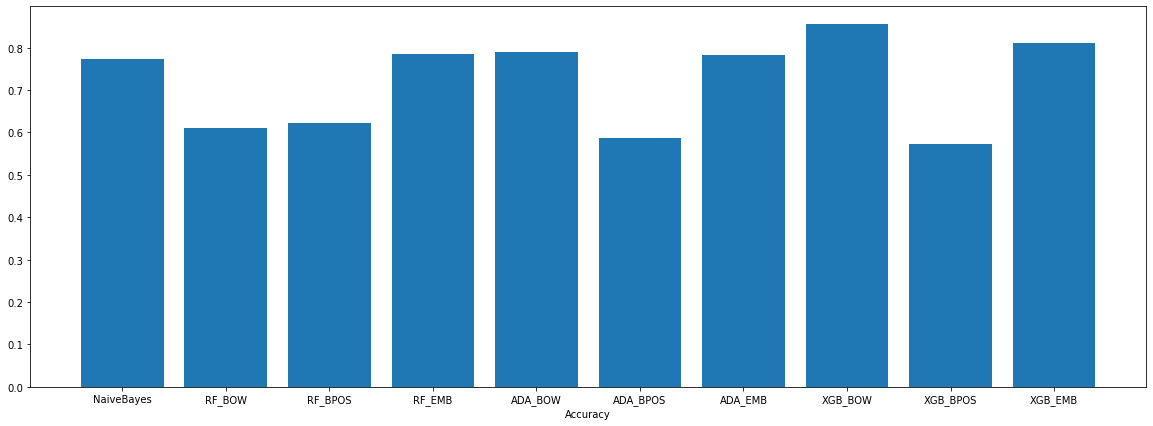

In [52]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('Accuracy')
keys = accuracy.keys()
values = accuracy.values()

plt.bar(keys, values)

<BarContainer object of 10 artists>

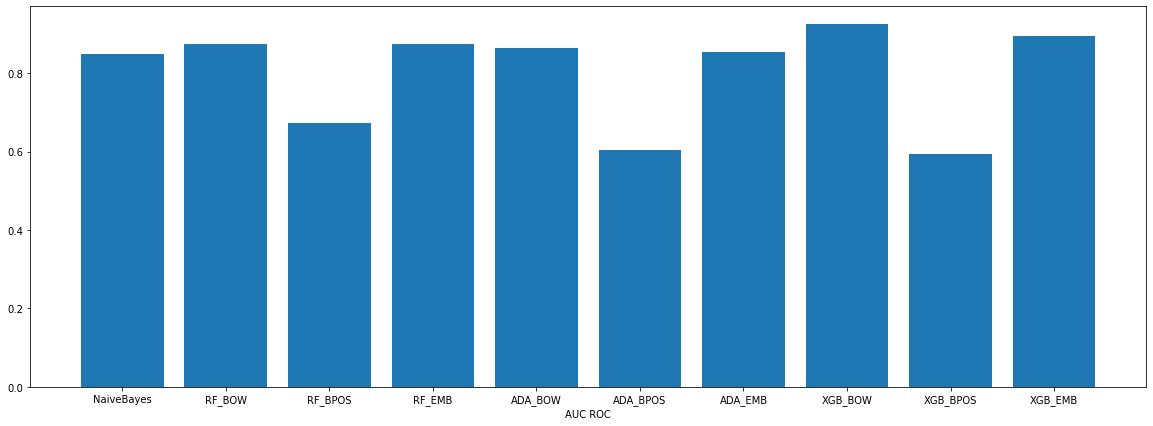

In [53]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xlabel('AUC ROC')
keys = auc_roc.keys()
values = auc_roc.values()

plt.bar(keys, values)